<a href="https://colab.research.google.com/github/hargurjeet/MachineLearning/blob/master/Nifty_50_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

High level steps to approach the problem statement

<br> Import the dataset
<br>  Visualize the Time Series Data
<br>  Make the time series data stationary
<br>  Plot the Correlation and AutoCorrelation Charts
<br> Construct the ARIMA Model or Seasonal ARIMA based on the data
<br> Use the model to make predictions


In [1]:
!pip install opendatasets 

In [4]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.2 MB/s 
     |████████████████████████████████| 9.8 MB 44.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [45]:
! pip install --upgrade git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-x5_s8pxy
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-x5_s8pxy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: Package 'statsmodels' requires a different Python: 3.7.12 not in '>=3.8'


In [47]:
!pip install pandas==0.19

     |████████████████████████████████| 9.5 MB 4.3 MB/s 
  ERROR: Failed building wheel for pandas
  Running setup.py clean for pandas
Failed to build pandas
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
    Running setup.py install for pandas ... error
  Rolling back uninstall of pandas
  Moving to /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/
   from /usr/local/lib/python3.7/dist-packages/~andas-1.1.5.dist-info
  Moving to /usr/local/lib/python3.7/dist-packages/pandas/
   from /usr/local/lib/python3.7/dist-packages/~andas
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-46q2mkbr/pandas_ed6813f322fe4249ab475c4747d8a2af/setup.py'"'"'; __file__='"'"'/tmp/pip-install-46q2mkbr/pandas_ed6813f322fe4249ab475c4747d8a2af/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', op

In [1]:
# Importing the dataset
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from fbprophet import Prophet
from matplotlib import pyplot as plt
import pandas.util.testing as tm
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
kaggle_url = 'https://www.kaggle.com/rohanrao/nifty50-stock-market-data?select=TITAN.csv'
od.download(kaggle_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hargurjeet
Your Kaggle Key: ··········


100%|██████████| 18.4M/18.4M [00:00<00:00, 37.6MB/s]


In [3]:
file_path = '/content/nifty50-stock-market-data/ASIANPAINT.csv'
df = pd.read_csv(file_path)

df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,ASIANPAINT,EQ,361.20,370.0,390.0,370.0,385.0,381.65,380.54,3318,1.262617e+11,NaN,NaN,NaN
1,2000-01-04,ASIANPAINT,EQ,381.65,380.0,392.0,375.0,390.0,385.55,383.50,4818,1.847699e+11,NaN,NaN,NaN
2,2000-01-05,ASIANPAINT,EQ,385.55,371.5,390.0,371.5,383.0,383.00,379.81,2628,9.981384e+10,NaN,NaN,NaN
3,2000-01-06,ASIANPAINT,EQ,383.00,384.9,384.9,374.5,375.1,377.50,379.88,3354,1.274114e+11,NaN,NaN,NaN
4,2000-01-07,ASIANPAINT,EQ,377.50,376.0,390.0,370.0,389.0,385.70,383.38,9589,3.676275e+11,NaN,NaN,NaN


In [4]:
## Visualize the time series

titan_opening_price = df[['Date', 'VWAP']]

titan_opening_price.set_index('Date', inplace=True)

titan_opening_price.index = pd.to_datetime(titan_opening_price.index, format="%Y-%m-%d")

titan_opening_price.head()

,VWAP
Date,
2000-01-03,380.54
2000-01-04,383.50
2000-01-05,379.81
2000-01-06,379.88
2000-01-07,383.38


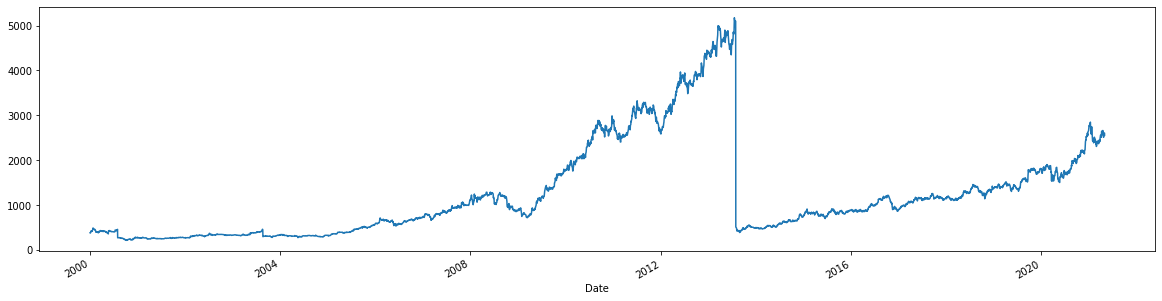

In [5]:
# visualize the data
plt.rcParams['figure.figsize'] = (20, 5)
titan_opening_price.VWAP.plot() ;

In [6]:
## testing for stationary
test_result=adfuller(titan_opening_price['VWAP'])

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Open):
    result=adfuller(Open)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [7]:
adfuller_test(titan_opening_price['VWAP'])

ADF Test Statistic : -2.1240473336295325
p-value : 0.23495562118424446
#Lags Used : 9
Number of Observations Used : 5296
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [8]:
## Performing time series decomposition

result=seasonal_decompose(x=titan_opening_price['VWAP'].head(365), model='multiplicable', freq=30)

result.seasonal.plot();

TypeError: ignored

In [ ]:
result.trend.plot();

In [ ]:
result.plot()

As the seasonal and trend component is not varing expotentially, this seems to be addtivie time series.

In [9]:
df = pd.read_csv("/content/nifty50-stock-market-data/ASIANPAINT.csv")
df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,ASIANPAINT,EQ,361.20,370.0,390.0,370.0,385.0,381.65,380.54,3318,1.262617e+11,NaN,NaN,NaN
2000-01-04,2000-01-04,ASIANPAINT,EQ,381.65,380.0,392.0,375.0,390.0,385.55,383.50,4818,1.847699e+11,NaN,NaN,NaN
2000-01-05,2000-01-05,ASIANPAINT,EQ,385.55,371.5,390.0,371.5,383.0,383.00,379.81,2628,9.981384e+10,NaN,NaN,NaN
2000-01-06,2000-01-06,ASIANPAINT,EQ,383.00,384.9,384.9,374.5,375.1,377.50,379.88,3354,1.274114e+11,NaN,NaN,NaN
2000-01-07,2000-01-07,ASIANPAINT,EQ,377.50,376.0,390.0,370.0,389.0,385.70,383.38,9589,3.676275e+11,NaN,NaN,NaN


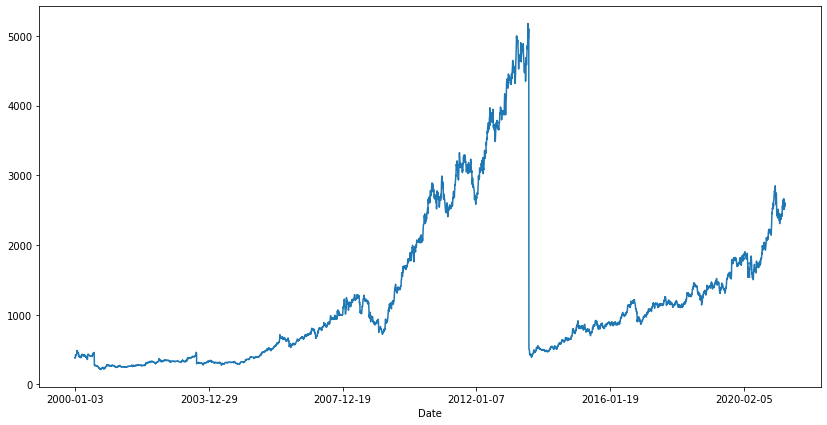

In [10]:
df.VWAP.plot(figsize=(14, 7))

In [11]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

In [12]:
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

In [13]:
df_mean_3d.head(5)

,index,High,Low,Volume,Turnover,Trades
0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,390.000000,370.000000,3318.0,1.262617e+11,NaN
2,2.0,391.000000,372.500000,4068.0,1.555158e+11,NaN
3,3.0,390.666656,372.166656,3588.0,1.369485e+11,NaN
4,4.0,388.966675,373.666656,3600.0,1.373317e+11,NaN


In [14]:
df_mean_7d

,index,High,Low,Volume,Turnover,Trades
0,0.0,NaN,NaN,NaN,NaN,NaN
1,1.0,390.000000,370.000000,3318.000,1.262617e+11,NaN
2,2.0,391.000000,372.500000,4068.000,1.555158e+11,NaN
3,3.0,390.666656,372.166656,3588.000,1.369485e+11,NaN
4,4.0,389.225006,372.750000,3529.500,1.345642e+11,NaN
...,...,...,...,...,...,...
5301,5301.0,2612.821533,2537.550049,1645358.625,4.245746e+14,85516.140625
5302,5302.0,2605.535645,2532.649902,1631608.625,4.205495e+14,83761.429688
5303,5303.0,2603.585693,2532.221436,1582537.375,4.078473e+14,83718.429688
5304,5304.0,2593.121338,2531.264404,1340363.750,3.425274e+14,73131.140625


In [15]:
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

In [16]:
for feature in lag_features:
  print(feature)

High
Low
Volume
Turnover
Trades


In [17]:
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,ASIANPAINT,EQ,361.20,370.0,390.0,370.0,385.0,381.65,380.54,3318,1.262617e+11,41346.011401,275128.103398,0.625572,1263.952393,1263.120239,1258.387329,14.421072,23.033878,51.562359,1230.239746,1229.427490,1224.801514,14.317530,22.876446,51.109859,509278.53125,508841.71875,505137.65625,183754.421875,226164.921875,280396.218750,6.931565e+13,6.920354e+13,6.824677e+13,2.504357e+13,3.080156e+13,3.775443e+13,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906
2000-01-04,2000-01-04,ASIANPAINT,EQ,381.65,380.0,392.0,375.0,390.0,385.55,383.50,4818,1.847699e+11,41346.011401,275128.103398,0.625572,390.000000,390.000000,390.000000,14.421072,23.033878,51.562359,370.000000,370.000000,370.000000,14.317530,22.876446,51.109859,3318.00000,3318.00000,3318.00000,183754.421875,226164.921875,280396.218750,1.262617e+11,1.262617e+11,1.262617e+11,2.504357e+13,3.080156e+13,3.775443e+13,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906
2000-01-05,2000-01-05,ASIANPAINT,EQ,385.55,371.5,390.0,371.5,383.0,383.00,379.81,2628,9.981384e+10,41346.011401,275128.103398,0.625572,391.000000,391.000000,391.000000,1.414214,1.414214,1.414214,372.500000,372.500000,372.500000,3.535534,3.535534,3.535534,4068.00000,4068.00000,4068.00000,1060.660156,1060.660156,1060.660156,1.555158e+11,1.555158e+11,1.555158e+11,4.137150e+10,4.137150e+10,4.137150e+10,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906
2000-01-06,2000-01-06,ASIANPAINT,EQ,383.00,384.9,384.9,374.5,375.1,377.50,379.88,3354,1.274114e+11,41346.011401,275128.103398,0.625572,390.666656,390.666656,390.666656,1.154701,1.154701,1.154701,372.166656,372.166656,372.166656,2.565801,2.565801,2.565801,3588.00000,3588.00000,3588.00000,1119.687500,1119.687500,1119.687500,1.369485e+11,1.369485e+11,1.369485e+11,4.347455e+10,4.347455e+10,4.347455e+10,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906
2000-01-07,2000-01-07,ASIANPAINT,EQ,377.50,376.0,390.0,370.0,389.0,385.70,383.38,9589,3.676275e+11,41346.011401,275128.103398,0.625572,388.966675,389.225006,389.225006,3.661056,3.033562,3.033562,373.666656,372.750000,372.750000,1.892969,2.397916,2.397916,3600.00000,3529.50000,3529.50000,1115.532104,921.677246,921.677246,1.373317e+11,1.345642e+11,1.345642e+11,4.333809e+10,3.581568e+10,3.581568e+10,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906


In [18]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,ASIANPAINT,EQ,361.20,370.0,390.0,370.0,385.0,381.65,380.54,3318,1.262617e+11,41346.011401,275128.103398,0.625572,1263.952393,1263.120239,1258.387329,14.421072,23.033878,51.562359,1230.239746,1229.427490,1224.801514,14.317530,22.876446,51.109859,509278.53125,508841.71875,505137.65625,183754.421875,226164.921875,280396.218750,6.931565e+13,6.920354e+13,6.824677e+13,2.504357e+13,3.080156e+13,3.775443e+13,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906,1,1,3,0
2000-01-04,2000-01-04,ASIANPAINT,EQ,381.65,380.0,392.0,375.0,390.0,385.55,383.50,4818,1.847699e+11,41346.011401,275128.103398,0.625572,390.000000,390.000000,390.000000,14.421072,23.033878,51.562359,370.000000,370.000000,370.000000,14.317530,22.876446,51.109859,3318.00000,3318.00000,3318.00000,183754.421875,226164.921875,280396.218750,1.262617e+11,1.262617e+11,1.262617e+11,2.504357e+13,3.080156e+13,3.775443e+13,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906,1,1,4,1
2000-01-05,2000-01-05,ASIANPAINT,EQ,385.55,371.5,390.0,371.5,383.0,383.00,379.81,2628,9.981384e+10,41346.011401,275128.103398,0.625572,391.000000,391.000000,391.000000,1.414214,1.414214,1.414214,372.500000,372.500000,372.500000,3.535534,3.535534,3.535534,4068.00000,4068.00000,4068.00000,1060.660156,1060.660156,1060.660156,1.555158e+11,1.555158e+11,1.555158e+11,4.137150e+10,4.137150e+10,4.137150e+10,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906,1,1,5,2
2000-01-06,2000-01-06,ASIANPAINT,EQ,383.00,384.9,384.9,374.5,375.1,377.50,379.88,3354,1.274114e+11,41346.011401,275128.103398,0.625572,390.666656,390.666656,390.666656,1.154701,1.154701,1.154701,372.166656,372.166656,372.166656,2.565801,2.565801,2.565801,3588.00000,3588.00000,3588.00000,1119.687500,1119.687500,1119.687500,1.369485e+11,1.369485e+11,1.369485e+11,4.347455e+10,4.347455e+10,4.347455e+10,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906,1,1,6,3
2000-01-07,2000-01-07,ASIANPAINT,EQ,377.50,376.0,390.0,370.0,389.0,385.70,383.38,9589,3.676275e+11,41346.011401,275128.103398,0.625572,388.966675,389.225006,389.225006,3.661056,3.033562,3.033562,373.666656,372.750000,372.750000,1.892969,2.397916,2.397916,3600.00000,3529.50000,3529.50000,1115.532104,921.677246,921.677246,1.373317e+11,1.345642e+11,1.345642e+11,4.333809e+10,3.581568e+10,3.581568e+10,41305.289062,41259.167969,40875.214844,12494.673828,15057.174805,17864.878906,1,1,7,4


In [19]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [20]:
model = auto_arima(df_train.VWAP, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.VWAP, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=54129.092, Time=23.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54497.965, Time=13.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=54265.679, Time=13.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=54179.885, Time=18.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=89782.255, Time=12.74 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=54127.691, Time=21.69 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=54126.085, Time=20.59 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=54126.563, Time=21.92 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54135.085, Time=19.44 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=54129.127, Time=22.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=54124.064, Time=20.83 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=54177.864, Time=18.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=54125.643, Time=20.84 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=54124.542, Time=21.68 sec
 ARIM

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
df_valid

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week,Forecast_ARIMAX,Forecast_Prophet
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2019-01-01,ASIANPAINT,EQ,1373.05,1373.2,1379.70,1358.60,1368.00,1371.55,1368.68,664707,9.097708e+13,17230.0,352333.0,0.5301,1381.916626,1396.435669,1356.903320,3.502975,25.210310,30.210526,1360.199951,1364.349976,1326.581665,6.582553,15.986896,30.997368,1.525905e+06,1813382.625,1445665.625,753881.875000,588503.93750,751292.5000,2.086644e+14,2.506013e+14,1.951788e+14,1.028031e+14,8.398322e+13,1.048536e+14,51390.667969,58106.714844,54042.734375,8306.593750,13952.493164,18609.033203,1,1,1,1,1330.296099,1310.078947
2019-01-02,2019-01-02,ASIANPAINT,EQ,1371.55,1367.0,1386.85,1361.60,1380.05,1383.30,1376.38,1233780,1.698145e+14,42748.0,639065.0,0.5180,1380.233276,1389.028564,1358.566650,2.542309,20.315714,30.040030,1361.633301,1360.000000,1328.094971,4.911551,11.718930,31.426798,1.022778e+06,1540021.625,1430712.375,591093.312500,617710.25000,762516.1875,1.399085e+14,2.112658e+14,1.933091e+14,8.049424e+13,8.522125e+13,1.062321e+14,37089.000000,51133.144531,53103.765625,17533.878906,20147.402344,19736.714844,1,1,2,2,1328.376581,1322.040777
2019-01-03,2019-01-03,ASIANPAINT,EQ,1383.30,1381.8,1393.85,1378.00,1387.00,1388.30,1388.80,1636293,2.272490e+14,87120.0,911907.0,0.5573,1381.516724,1382.307129,1360.466675,4.696364,5.023729,29.963596,1362.500000,1357.042847,1329.981689,4.419276,6.684025,31.690359,8.656933e+05,1416552.375,1445683.625,319222.343750,572284.25000,753752.7500,1.189096e+14,1.936480e+14,1.955401e+14,4.415462e+13,7.790830e+13,1.049628e+14,34527.667969,46040.285156,53553.234375,14986.345703,16232.091797,19324.316406,1,1,3,3,1345.375734,1335.892970
2019-01-04,2019-01-04,ASIANPAINT,EQ,1388.30,1388.0,1401.40,1381.40,1383.00,1385.85,1393.55,1202397,1.675602e+14,58130.0,578860.0,0.4814,1386.800049,1383.007202,1362.560059,7.075132,6.286323,30.031216,1366.066650,1360.885742,1332.425049,10.442861,9.734549,32.489567,1.178260e+06,1414654.750,1471302.375,488166.656250,571404.12500,746457.4375,1.626802e+14,1.939774e+14,1.993059e+14,6.841549e+13,7.806741e+13,1.039685e+14,49032.667969,52750.285156,55372.832031,35366.308594,22055.095703,19839.835938,1,1,4,4,1353.522298,1342.394033
2019-01-07,2019-01-07,ASIANPAINT,EQ,1385.85,1386.0,1405.40,1383.75,1395.60,1396.00,1396.46,1074373,1.500315e+14,43071.0,679696.0,0.6326,1394.033325,1386.792847,1364.523315,7.276732,8.259914,30.594593,1373.666626,1365.742798,1334.680054,10.587414,10.347280,33.481251,1.357490e+06,1330699.000,1465556.000,241959.828125,549815.12500,747888.2500,1.882079e+14,1.830849e+14,1.988067e+14,3.382935e+13,7.522338e+13,1.040877e+14,62666.000000,51342.855469,55465.367188,22531.091797,21219.621094,19846.218750,1,2,7,0,1381.680191,1376.253867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,ASIANPAINT,EQ,2517.95,2530.0,2575.00,2530.00,2558.00,2557.90,2557.47,1103980,2.823400e+14,58557.0,335232.0,0.3037,2575.566650,2612.821533,2538.456787,25.545319,48.140800,87.391151,2504.333252,2537.550049,2472.416748,21.581783,35.974911,86.856834,1.598213e+06,1645358.625,1939955.875,101729.429688,527266.37500,910881.3125,4.045954e+14,4.245746e+14,4.848710e+14,2.135105e+13,1.442763e+14,2.241081e+14,80026.6

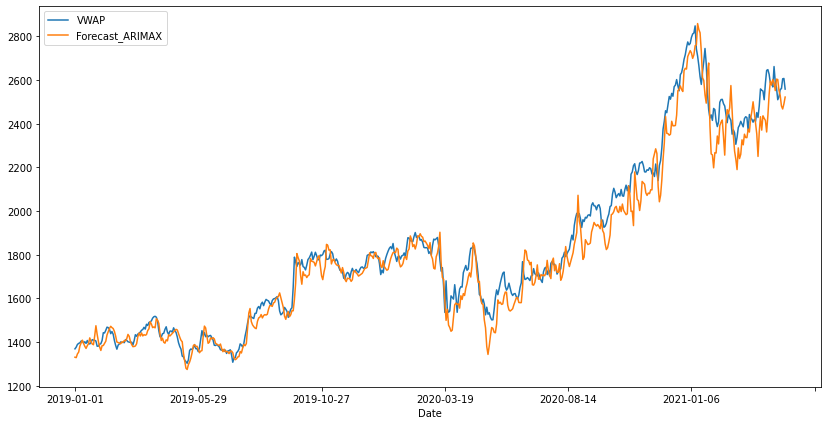

In [21]:
df_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [22]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 77.08157118841062

MAE of Auto ARIMAX: 57.51340410732787


Facebook prophet

In [33]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



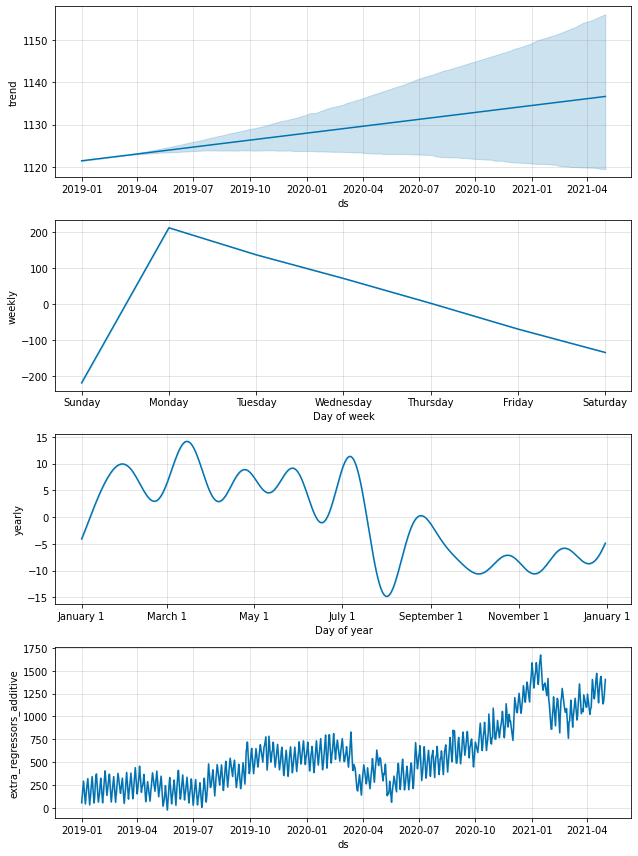

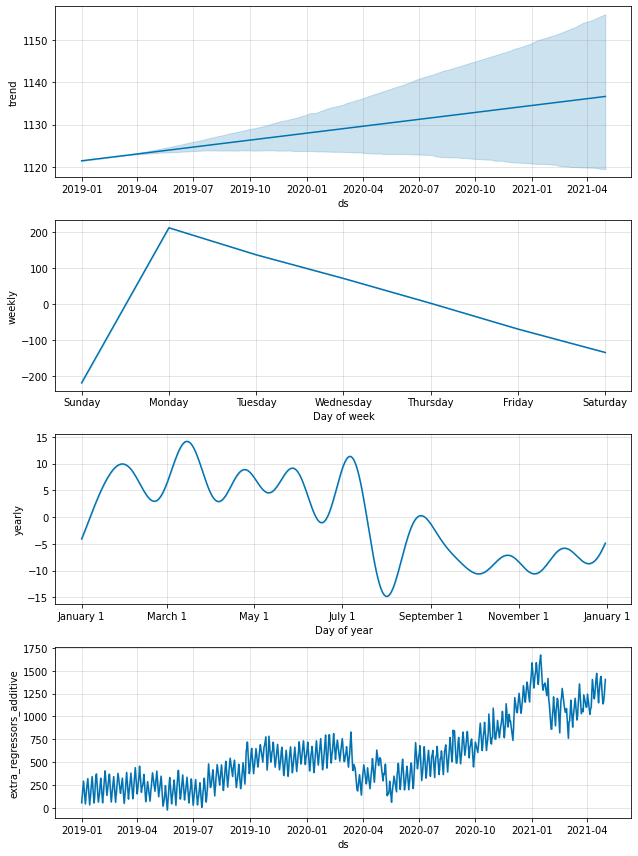

In [24]:
model_fbp.plot_components(forecast)

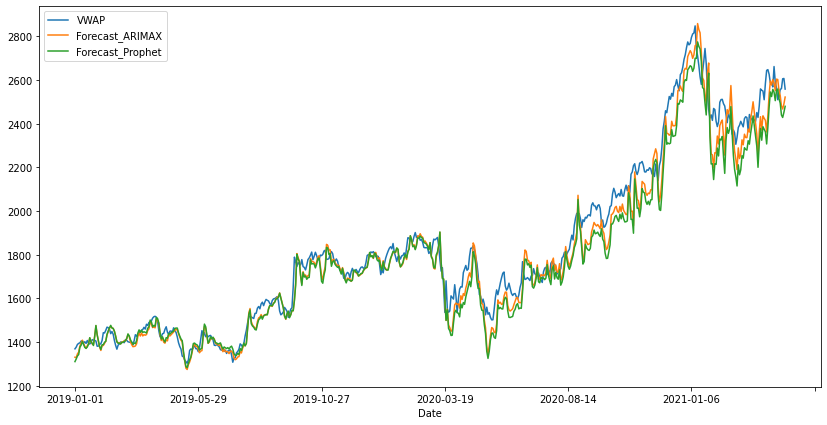

In [25]:
df_valid[["VWAP", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [26]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 77.08157118841062
RMSE of Prophet: 96.37385913150563

MAE of Auto ARIMAX: 57.51340410732787
MAE of Prophet: 71.24509692659416
